# Notebook to load the test data and model and evaluate the model on test data to compare the results

Model Evaluation on small Test data (3 subjects).

1. Results on Test data using model trained from scratch
2. Results on Test data using model published by authors.


Model Evaluation on bigger Test data (14 subjects).

1. Results on Test data using model published by authors.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
#! git clone https://github.com/NYUMedML/CNN_design_for_AD.git

In [3]:
cd /content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/

/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA


In [4]:
ls

subjects/  TSV_FOR_TEST/  TSV_FOR_TRAIN/  TSV_TEST_FULL/


In [5]:
ls /content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/subjects/

sub-ADNI002S0685/  sub-ADNI033S1016/  sub-ADNI073S0746/  sub-ADNI130S1290/
sub-ADNI007S0068/  sub-ADNI033S1281/  sub-ADNI094S1397/  sub-ADNI133S0792/
sub-ADNI027S1082/  sub-ADNI051S1072/  sub-ADNI126S0606/
sub-ADNI029S0866/  sub-ADNI051S1296/  sub-ADNI128S1407/


### List of subjects in test data

In [6]:
cat /content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/TSV_FOR_TEST/Test_diagnosis_ADNI.tsv

participant_id	session_id	diagnosis	mmse	cdr	cdr_sb	age	examination_date	earliest_time	age_rounded
sub-ADNI002S0685	ses-M00	CN	30.0	0.0	0.0	89.6	2006-07-20	2006-07-20	89.5
sub-ADNI002S0685	ses-M06	CN	29.0	0.0	0.0	90.1284052019165	2007-01-29	2006-07-20	90.0
sub-ADNI002S0685	ses-M12	CN	27.0	0.0	0.0	90.63490759753593	2007-08-02	2006-07-20	90.5
sub-ADNI002S0685	ses-M24	CN	30.0	0.0	0.0	91.69171800136893	2008-08-22	2006-07-20	91.5
sub-ADNI002S0685	ses-M36	CN	23.0	0.0	0.0	92.60889801505817	2009-07-23	2006-07-20	92.5
sub-ADNI051S1296	ses-M00	AD	25.0	0.5	4.0	76.9	2007-03-01	2007-03-01	77.0
sub-ADNI051S1296	ses-M06	AD	23.0	0.5	4.0	77.43388090349076	2007-09-12	2007-03-01	77.5
sub-ADNI051S1296	ses-M12	AD	24.0	1.0	6.0	77.93216974674881	2008-03-12	2007-03-01	78.0
sub-ADNI051S1296	ses-M24	AD	22.0	1.0	5.5	78.92600958247776	2009-03-10	2007-03-01	79.0
sub-ADNI073S0746	ses-M00	MCI	30.0	0.5	1.5	73.8	2007-01-25	2007-01-25	74.0
sub-ADNI073S0746	ses-M06	MCI	29.0	0.5	1.0	74.30102669404518	2007-07-27	2007-01-2

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import os

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
from numpy.random import permutation
import yaml
from yaml.loader import SafeLoader,FullLoader,BaseLoader,UnsafeLoader

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
cd /content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/

/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD


In [11]:
config_name = 'config.yaml'
with open(os.path.join('./'+config_name), 'r') as f:
    cfg = yaml.safe_load(f)



In [12]:
from datasets.adni_3d import ADNI_3D
from models.build_model import build_model

In [13]:
dir_to_scans = '/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/subjects'
dir_to_tsv = '/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/TSV_FOR_TEST/'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)   

In [14]:
category = ['CN','MCI','AD']


In [15]:
def visualize_example(Test_dataset,sub_id):
    plt.figure(figsize=(10, 10))
    image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[26,:,:]),cmap = 'gray')
    plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]] , fontsize=10)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,57,:]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,50]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)

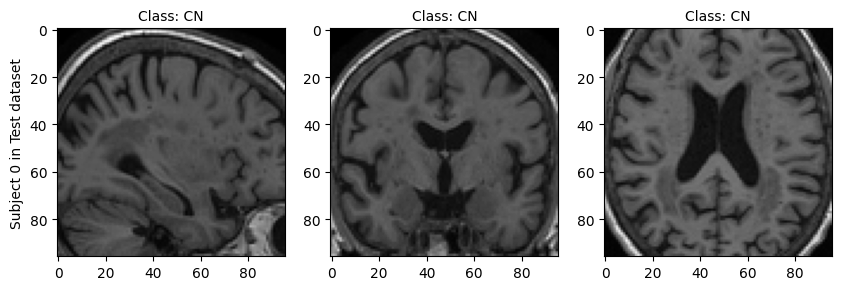

In [16]:
visualize_example(Test_dataset,0)

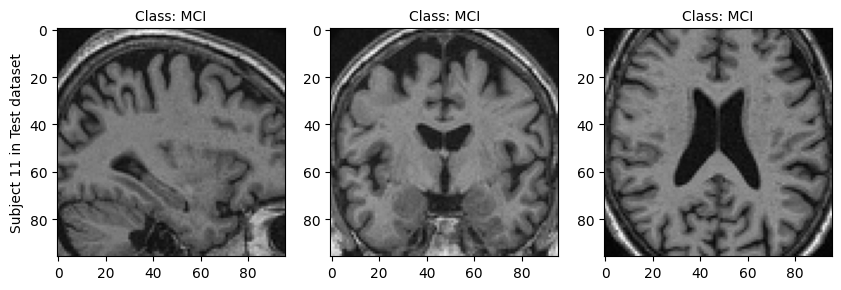

In [17]:
visualize_example(Test_dataset,11)

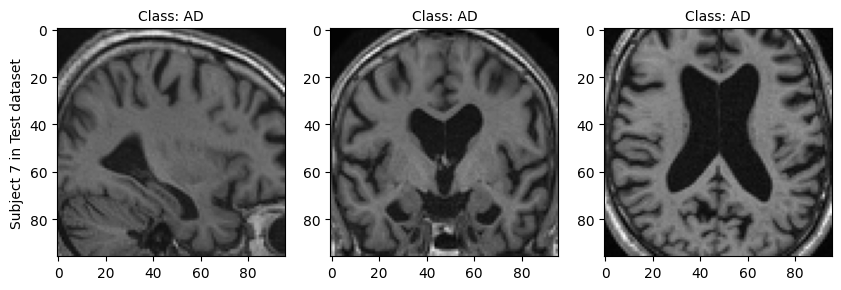

In [18]:
visualize_example(Test_dataset,7)

In [19]:
from sklearn.metrics import confusion_matrix
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [20]:
def calc_aucs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc

In [21]:
def plot_rocs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc[k+1] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc[k+2] = auc(fpr["macro"], tpr["macro"])
    plotting_fpr = []
    plotting_tpr = []
    for k in range(cfg['model']['n_label']):
        plotting_fpr.append(fpr[k])
        plotting_tpr.append(tpr[k])
    plotting_fpr += [fpr["micro"], fpr["macro"]]
    plotting_tpr += [tpr["micro"], tpr["macro"]]
    auc_outs = [plotting_fpr, plotting_tpr, roc_auc]
    name = ['CN vs all ','MCI vs all ', 'AD vs all ', 'Micro ', 'Macro ']             
    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
    plt.figure()
    for i, color in zip(range(len(auc_outs[0])), colors):
        plt.plot(auc_outs[0][i], auc_outs[1][i], color=color, lw=2, label=name[i] + 'ROC curve (area = %0.2f)' % auc_outs[2][i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curves')
    plt.legend(loc="lower right")

In [22]:
def run_epoch(model,val_loader,use_age=False):
    logit_all = []
    target_all = []
    mmse_all = []
    patient_idx_all = []
    cdr_all = []
    for i, (input, target, patient_idx, mmse, cdr_sub, age_id) in enumerate(val_loader):
        if i % 20 == 0:
            print('Iteration: ',i)
        input = input.to(device)
        target = target.to(device)
        if use_age:
            age_id = age_id.to(device)
        else:
            age_id = None
        logit = model(input,age_id)
        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        mmse_all.append(mmse.cpu())
        patient_idx_all.append(patient_idx.cpu())
        cdr_all.append(cdr_sub.cpu())
    
    logit_all_catted = torch.cat(logit_all)
    target_all_catted = torch.cat(target_all)
    mmse_all_catted = torch.cat(mmse_all)
    patient_idx_all_catted = torch.cat(patient_idx_all)
    cdr_all_catted = torch.cat(cdr_all)
    return logit_all_catted.numpy(), target_all_catted.numpy(), mmse_all_catted.numpy(), patient_idx_all_catted.numpy(), cdr_all_catted.numpy() 
    

In [23]:
def evaluation_models(model_name,data_loader, expansion_list = [1],  num_trails = 10,percentage = 0.8, use_age = False, norm_type= 'Instance'):
    
    all_acc = np.zeros((len(expansion_list),num_trails))
    all_balanced_acc = np.zeros((len(expansion_list),num_trails))
    all_auc = []
    for i,ep in enumerate(expansion_list):
        cfg['model']['expansion'] = ep
        cfg['model']['norm_type'] = norm_type
        model = build_model(cfg)
        best_model_dir = './saved_model/'
        pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cpu')['state_dict']
        old_ks = list(pretrained_dict.keys()).copy()
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:]in model_dict.keys())}
        model_dict.update(pretrained_dict) 
        model.load_state_dict(model_dict)
        model = model.to(device)
        model = model.eval()
        logit_all,target_all,_,_,_= run_epoch(model, data_loader, use_age)
        #print(F.softmax(torch.tensor(logit_all[0:20]),dim=1))
        tes_auc = []
        for tes in range(num_trails):
            rand_idex = permutation(range(len(target_all)))[:int(percentage*len(target_all))]
            target_test = target_all[rand_idex]
            pred_test = np.argmax(logit_all,1)[rand_idex]
            logit_test = logit_all[rand_idex]
            all_acc[i,tes] =accuracy_score(target_test, pred_test)
            all_balanced_acc[i,tes] =balanced_accuracy_score(target_test, pred_test)
            tes_auc.append(calc_aucs(target_test,logit_test))
        plot_rocs(target_test,logit_test)
        all_auc.append(tes_auc)
        print(old_ks)
        print(list(pretrained_dict.keys()))
        
    return all_acc, all_balanced_acc, all_auc

In [24]:
def test_model(all_acc, all_balanced_acc,all_auc):
    for w_k in range(len(all_acc)):
        print('Mean Acc ', np.mean(all_acc[w_k]),'\t')
        print('STD Acc ', np.std(all_acc[w_k]),'\t')
        print('Mean Balanced Acc ', np.mean(all_balanced_acc[w_k]),'\t')
        print('std Balanced Acc ', np.std(all_balanced_acc[w_k]),'\t')
        avg_micro = []
        avg_macro = []
        for d in all_auc[w_k]:
            avg_micro.append( d['micro'])
            avg_macro.append( d['macro'])
        print('Micro mean: ',np.mean(avg_micro))
        print('Micro std: ', np.std(avg_micro))
        print('Macro mean: ',np.mean(avg_macro))
        print('Macro std: ',np.std(avg_macro))

In [25]:
model = build_model(cfg)
#model_file_name = 'age_expansion_8'
model_file_name = '1007_pooling_age_train_perc_100.0_expansion_0'


# Results on Test Data using model trained from scratch

Iteration:  0
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'model.classifier.

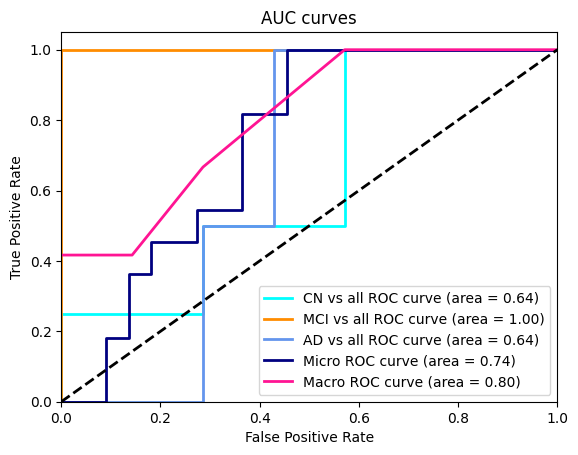

In [26]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')


In [27]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.5181818181818181 	
STD Acc  0.09136250564655354 	
Mean Balanced Acc  0.5238888888888888 	
std Balanced Acc  0.05550275268448906 	
Micro mean:  0.7413223140495867
Micro std:  0.025080976703295024
Macro mean:  0.8282440476190475
Macro std:  0.03992617133905823


# Model Results on Test data using TRAINED MODEL published by Authors

In [28]:
model = build_model(cfg)
model_file_name = 'age_expansion_8'
#model_file_name = '1007_pooling_age_train_perc_100.0_expansion_0'

Iteration:  0
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'model.classifier.

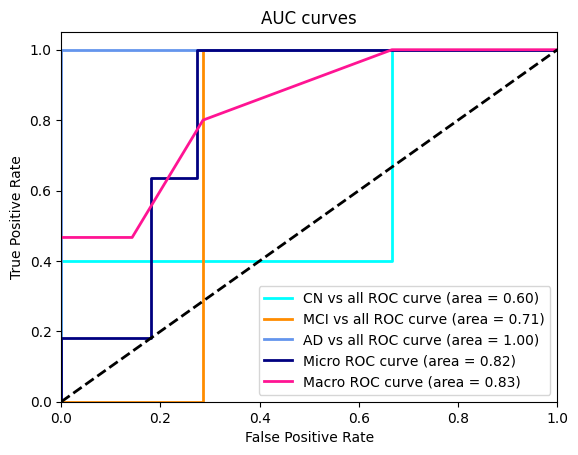

In [29]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')


In [31]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.6636363636363638 	
STD Acc  0.0416597790450531 	
Mean Balanced Acc  0.6666666666666667 	
std Balanced Acc  1.1102230246251565e-16 	
Micro mean:  0.8181818181818181
Micro std:  0.021943666193969844
Macro mean:  0.7962648809523809
Macro std:  0.026552204998858332


# Results on bigger Test data 14 subjects using pre trained model published by authors.

This should match the results published by authors.

Iteration:  0
Iteration:  20
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'mo

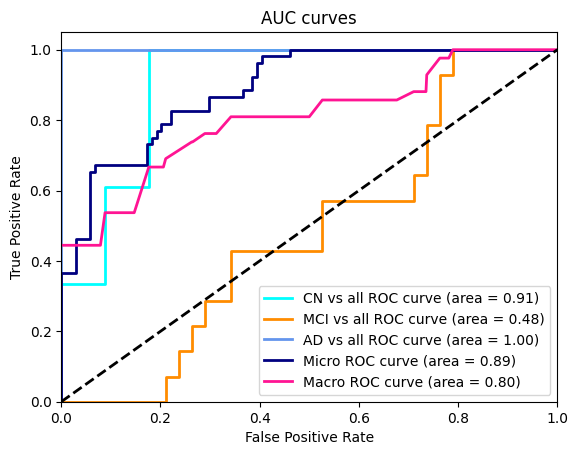

In [33]:
dir_to_scans = '/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/subjects'
dir_to_tsv = '/content/gdrive/MyDrive/Visual_Computing/CNN_design_for_AD/FULL_DATA/TSV_TEST_FULL/'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)   


model = build_model(cfg)
model_file_name = 'age_expansion_8'

all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')

test_model(all_acc, all_balanced_acc,all_auc)

### This is similar to  as published by the authors.